# Covid-19: From model prediction to model predictive control

## Scenario-analysis with the age-stratified deterministic model

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook was made to quickly perform scenario analysis with the age-stratified model implementation.

### Load required packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st
import networkx # to install networkx in your environment: conda install networkx
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

### Load interaction matrices

In [2]:
# Load interaction matrices
Nc_home = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELhome.txt", dtype='f', delimiter='\t')
Nc_work = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELwork.txt", dtype='f', delimiter='\t')
Nc_schools = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELschools.txt", dtype='f', delimiter='\t')
Nc_transport = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELtransport.txt", dtype='f', delimiter='\t')
Nc_leisure = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELleisure.txt", dtype='f', delimiter='\t')
Nc_others = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELothers.txt", dtype='f', delimiter='\t')
Nc_total = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELtotal.txt", dtype='f', delimiter='\t')
initN = np.loadtxt("../../data/raw/polymod/interaction_matrices/Belgium/BELagedist_10year.txt", dtype='f', delimiter='\t')

### Initialise model

In [3]:
h = np.array([[0.0001,0.0003,0.012,0.032,0.049,0.102,0.166,0.243,0.273]])
icu = np.array([0.05,0.05,0.05,0.05,0.063,0.122,0.274,0.432,0.709])

In [4]:
model = models.SEIRSAgeModel(initN   = initN,         #16x0 numpy array
                                     beta    = 0.0622, # probability of infection when encountering infected person
                                     sigma   = 2.0, # latent period
                                     omega   = 3.2, # pre-symptomatic infectious period
                                     Nc = Nc_total, #must be a numpy array; average number of human-to-human interactions per day
                                     a = 0.43, # probability of an asymptotic (supermild) infection
                                     m = 1-0.43, # probability of a mild infection
                                     h = h, # probability of hospitalisation for a mild infection
                                     c = 1-icu, # probability of hospitalisation in cohort
                                     da = 7, # days of infection when asymptomatic (supermild)
                                     dm = 7, # days of infection when mild
                                     dc = 7,
                                     dICU = 8,
                                     dICUrec = 7,
                                     dhospital = 7.5, # days before reaching the hospital when heavy or critical
                                     #m0 = np.transpose(np.array([0.000094,0.00022,0.00091,0.0018,0.004,0.013,0.046,0.098,0.18])), # mortality in ICU
                                     m0 = np.ones(9)*0.50,
                                     totalTests = 0,
                                     psi_FP = 0, # probability of a false positive
                                     psi_PP = 1, # probability of a correct test
                                     dq = 14, # days in quarantaine                          
                                     initE = np.array([1,1,1,0,0,0,0,0,0]), #must be a numpy array
                                     initI = np.zeros(9),
                                     initA = np.zeros(9), 
                                     initM = np.zeros(9),
                                     initC = np.zeros(9),
                                     initCicurec = np.zeros(9),
                                     initICU = np.zeros(9),
                                     initR = np.zeros(9),
                                     initD = np.zeros(9),
                                     initSQ = np.zeros(9),
                                     initEQ = np.zeros(9),
                                     initIQ = np.zeros(9),
                                     initAQ = np.zeros(9),
                                     initMQ = np.zeros(9),
                                     initRQ = np.zeros(9),
                                     monteCarlo = False,
                                     n_samples = 1,
                            )

### Scrape high-level Sciensano data

In [5]:
index,startdate,H_tot, ICU_tot, H_in, H_out= sciensano.get_sciensano_data()

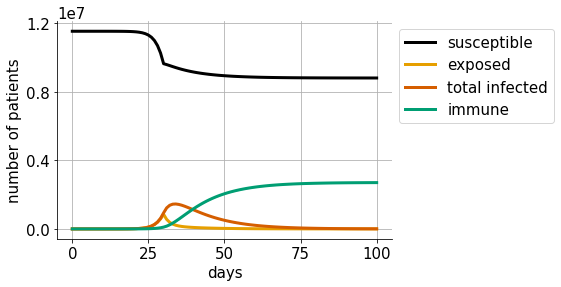

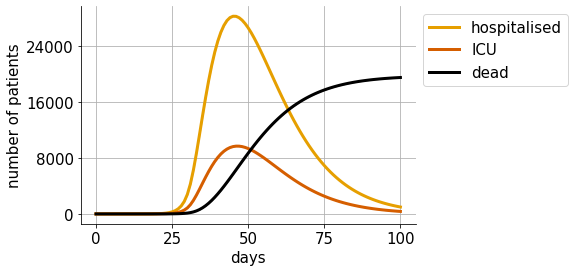

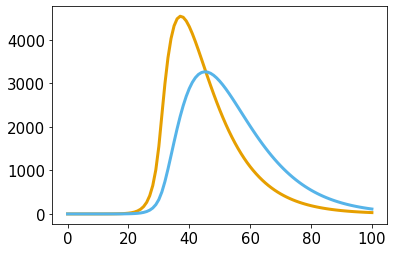

In [6]:
# Create checkpoints dictionary
chk = {'t':       [31], 
       'Nc':      [0.3*Nc_home]
      }
# Run simulation
y = model.sim(100,checkpoints=chk)
# Visualise
model.plotPopulationStatus()
model.plotInfected()
plt.plot(model.tseries,model.sumH_in)
plt.plot(model.tseries,model.sumH_out)

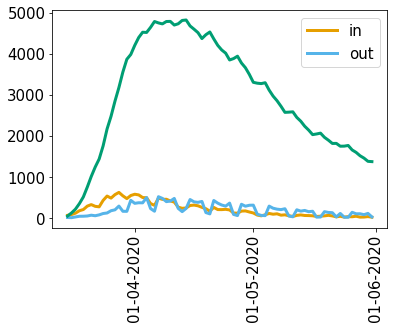

In [7]:
H_net = H_in - H_out
H_tot_cumsum = np.cumsum(H_net)
H_tot_cumsum=np.reshape(H_tot_cumsum,(1,H_tot_cumsum.size))
plt.plot(index,np.transpose(H_in))
plt.plot(index,np.transpose(H_out))
plt.plot(index,np.transpose(H_tot_cumsum))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d-%m-%Y'))
plt.setp(plt.gca().xaxis.get_majorticklabels(),
    'rotation', 90)
plt.legend(('in','out'))
plt.show()

### Perform calibration

First calibrate $\beta$ and $t_e$ to the first days of the pandemic.

In [8]:
data=[np.transpose(H_in[:,0:7]),np.transpose(H_out[:,0:7])]
# set optimisation settings
parNames = ['extraTime','beta'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=((5,100),(0.02,0.08)) # must be a list!
weights = np.array([1,1])
# run optimisation
#theta = model.fit(data,parNames,positions,bounds,weights,setvar=True,maxiter=30,popsize=100)

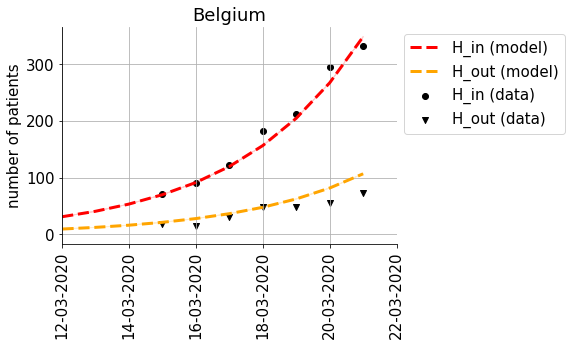

In [9]:
model.extraTime=int(round(37.36))
model.beta=0.03492
# plot result
model.plotFit(index[0:7],data,positions,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

Then calibrate hospitalization lengths from the actual peak.

In [12]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+12], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:50]),np.transpose(H_out[:,0:50])]
# set optimisation settings
parNames = ['dc'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=[((1,15))] # must be a list!
weights = np.array([1,1])
# run optimisation
#theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=30,popsize=100)

No constraints given.
Best after iteration 1: [12.52960535] 660954.5975930885
Best after iteration 2: [12.52960535] 660954.5975930885
Best after iteration 3: [12.52960535] 660954.5975930885
New best for swarm at iteration 4: [12.05846801] 660875.4754107895
Best after iteration 4: [12.05846801] 660875.4754107895
New best for swarm at iteration 5: [12.37223465] 660865.3242946396
Best after iteration 5: [12.37223465] 660865.3242946396
New best for swarm at iteration 6: [12.19430275] 660839.5803476536
Best after iteration 6: [12.19430275] 660839.5803476536
Best after iteration 7: [12.19430275] 660839.5803476536
Best after iteration 8: [12.19430275] 660839.5803476536
New best for swarm at iteration 9: [12.1981754] 660839.2708938658
Best after iteration 9: [12.1981754] 660839.2708938658
New best for swarm at iteration 10: [10.76678958] 660826.0501427205
Best after iteration 10: [10.76678958] 660826.0501427205
New best for swarm at iteration 11: [10.49590577] 660824.7781329335
Best after iter

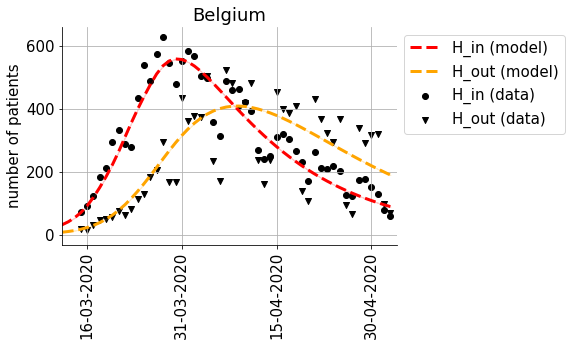

In [13]:
model.dc=10.49
# plot result
model.plotFit(index[0:50],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

In [10]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+13], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:55]),np.transpose(H_out[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=((7,12),(6,16)) # must be a list!
weights = np.array([1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=100)

No constraints given.
Best after iteration 1: [11.89299591  6.91355374] 746432.4397829169
New best for swarm at iteration 2: [ 8.60438868 16.        ] 745632.675987395
Best after iteration 2: [ 8.60438868 16.        ] 745632.675987395
New best for swarm at iteration 3: [ 9.26140284 11.01774671] 744872.4733555246
Best after iteration 3: [ 9.26140284 11.01774671] 744872.4733555246
New best for swarm at iteration 4: [ 9.89971255 12.4301689 ] 744829.0346860645
Best after iteration 4: [ 9.89971255 12.4301689 ] 744829.0346860645
New best for swarm at iteration 5: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 5: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 6: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 7: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 8: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 9: [ 8.42078924 14.71503589] 744321.9892519426
Best after iteration 10: [ 8.42078924 14.71503589] 7

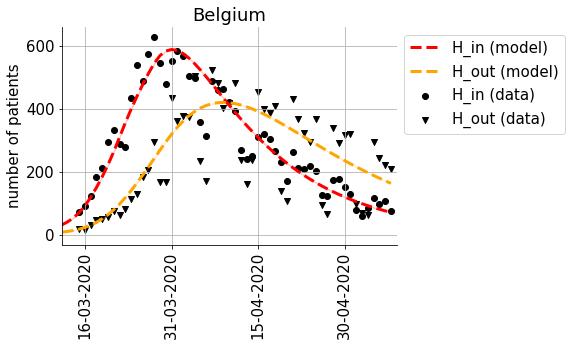

In [11]:
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

No constraints given.
Best after iteration 1: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 2: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 3: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 4: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 5: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 6: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 7: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 8: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 9: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Best after iteration 10: [ 7.54275694 10.62111347  5.64020824] 744084.7245367507
Stopping search: maximum iterations reached --> 10


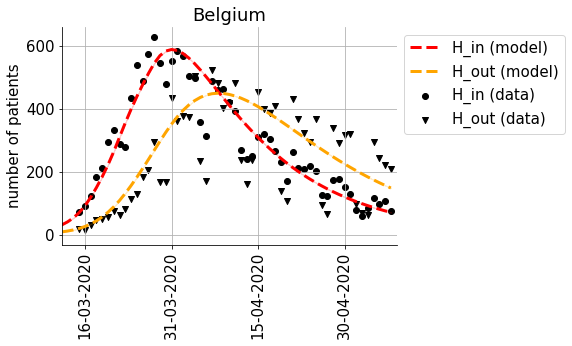

In [24]:
sigma = 0.5
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+7,model.extraTime+13], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(H_in[:,0:55]),np.transpose(H_out[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU','dICUrec'] # must be a list!
positions = [np.array([14]),np.array([15])] # must be a list!
bounds=((5,11),(10,16),(4,9)) # must be a list!
weights = np.array([1,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=300)
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

No constraints given.
Best after iteration 1: [11.89195923  8.71666005  6.6214246 ] 2514147.595870625
Best after iteration 2: [11.89195923  8.71666005  6.6214246 ] 2514147.595870625
Best after iteration 3: [11.89195923  8.71666005  6.6214246 ] 2514147.595870625
New best for swarm at iteration 4: [12.          9.2692192   6.41481593] 2440236.5126989544
Best after iteration 4: [12.          9.2692192   6.41481593] 2440236.5126989544
New best for swarm at iteration 5: [11.98496403  8.98159776  7.11615267] 2436967.052385375
Best after iteration 5: [11.98496403  8.98159776  7.11615267] 2436967.052385375
New best for swarm at iteration 6: [12.          9.20739575  7.22069191] 2407579.216772562
Best after iteration 6: [12.          9.20739575  7.22069191] 2407579.216772562
New best for swarm at iteration 7: [11.651667    8.85159707  7.62850085] 2364991.769324147
Best after iteration 7: [11.651667    8.85159707  7.62850085] 2364991.769324147
Best after iteration 8: [11.651667    8.85159707  7.

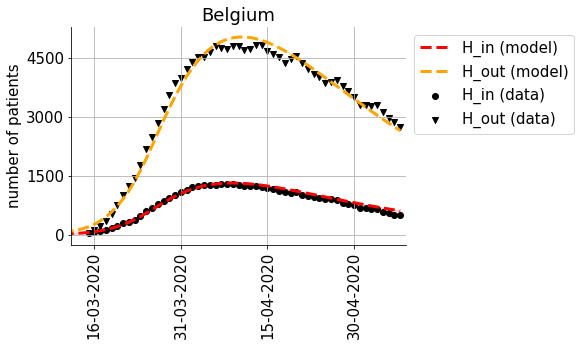

In [11]:
sigma = 0.8
Nc1 = Nc_home+((1-0.20)*Nc_work+(1-0.20)*Nc_transport+0.5*Nc_leisure)
Nc2 = 0.6*Nc_home+((1-0.50)*Nc_work+(1-0.50)*Nc_transport)
Nc3 = 0.3*Nc_home+sigma*((1-0.70)*Nc_work+(1-0.70)*Nc_transport)

# Create a dictionary of past policies
chk = {'t':       [model.extraTime+2,model.extraTime+8,model.extraTime+10], 
       'Nc':      [Nc1,Nc2,Nc3]
      }

data=[np.transpose(ICU_tot[:,0:55]),np.transpose(H_tot_cumsum[:,0:55])]
# set optimisation settings
parNames = ['dc','dICU','dICUrec'] # must be a list!
positions = [np.array([6]),np.array([5,6])] # must be a list!
bounds=((6,12),(6,10),(4,9)) # must be a list!
weights = np.array([9,1])
# run optimisation
theta = model.fit(data,parNames,positions,bounds,weights,checkpoints=chk,setvar=True,maxiter=10,popsize=100)
# plot result
model.plotFit(index[0:55],data,positions,checkpoints=chk,modelClr=['red','orange','blue','yellow'],legendText=('H_in (model)','H_out (model)','H_in (data)','H_out (data)'),titleText='Belgium')

Slight underestimation of hospitalizations, most likely due to the fact that residence times in the hospital differ from the values used in our model. Using the UZ Ghent data to estimate distributions and incorporating this uncertainty will surely fix this in the future.

### Sample from the posterior distribution of beta

For now, the high-level python package `pyMC3` is used to sample from the posterior distribution of $\beta$. However, due to the high level nature of `pyMC3` it is hard to perform an elegant coupling with the BIOMATH covid-19 model. Because the parameter $\beta$ and the excess time $t_e$ are correlated, we fix the $t_e$ estimate obtained from MLE during the sampling procedure to avoid having a bi- or trimodal distributions for $\beta$.

In [ ]:
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

In [ ]:
n=theano.shared(float(ICUvect[:,0:idx].size))

@as_op(itypes=[tt.dscalar,tt.dscalar], otypes=[tt.dvector])
def couple2COVID19MODEL(beta,n):
    model.beta = beta
    T = n+model.extraTime-1
    model.sim(T,checkpoints=chk)
    out = (model.sumS,model.sumE,model.sumA,model.sumM,model.sumCtot,model.sumMi,model.sumICU,model.sumR,model.sumD,model.sumSQ,model.sumEQ,model.sumAQ,model.sumMQ,model.sumRQ)
    positions=np.array([5,6])
    for i in range(int(n)):
        som = 0
        for j in positions:
            som = som + np.mean(out[j],axis=1).reshape(np.mean(out[j],axis=1).size,1)
    return som[int(model.extraTime):].flatten()

with pm.Model() as COVID19MODEL:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=model.beta, sigma=0.01)
    sigma = pm.HalfNormal('sigma', sigma=20)

    mu = couple2COVID19MODEL(beta,n)
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=ICUvect[:,0:idx].flatten())

In [ ]:
map_estimate = pm.find_MAP(model=COVID19MODEL, method='L-BFGS-B',tol=1e-12)
map_estimate

In [ ]:
with COVID19MODEL:

    # draw 1000 posterior samples
    trace = pm.sample(10000,start=map_estimate,step=pm.Slice(),cores=12)

In [ ]:
pm.traceplot(trace,varnames=['beta','sigma'])

### Scenarios


Use the code snippet below to see the correspondence between `'t'` in the `pastPolicy` dictionary and the actual date.

In [ ]:
# Define data as a list containing data timeseries
data=[np.transpose(ICUvect),np.transpose(hospital)]
# vector with dates
index=pd.date_range(startdate, freq='D', periods=ICUvect.size)
print(index[2],index[50],index[57],index[-1])

The interaction matrices of the 2008 study by Mossong were gathered under a business-as-usual scenario. It is thus not possible to use the interaction matrices without doing a correction for social distancing. Even when using only the interactions at home (`Nc_home`), the virus cannot be stopped.

In [ ]:
sigma1 = 1
sigma2 = 0.1 # rule of four
sigma3 = 0.1 # Arbitrary increase after further relaxing of measures on June 4th

Stringent measures were taken in the evening of March 17th, which corresponds to time-index 3, however, the measures are only 'enforced' on day 8 in the `pastPolicy` dictionary. Why? The change in human behaviour was very gradual, it took between 10-14 days after March 17th before everyone was working at home (see the Google mobility report). In other words, measures were taken on March 17th, but obedience for these measures was gradual, like a ramp. However, in the model we make a step-wise change. The obedience to measures can be adressed in future work.

In [ ]:
dates,retail_recreation,grocery,parks,transport,work,residential=google.get_google_mobility_data()

Another important issue to adress is the home interaction matrix `Nc_home`. All contacts in these matrices are still assumed to be random, during a lockdown, the interactions at home should somehow be corrected for the 'bubble' effect. Since the average household size in belgium is 2 people, I correct the `Nc_home` matrix with a factor 1/2.

In [ ]:
# Create a dictionary of past policies
pastPolicy = {'t':       [7,50,57], 
              'Nc':      [0.3*Nc_home+sigma1*((1-0.70)*Nc_work+(1-0.70)*Nc_transport),
                          # 70 percent reduction in work --> from data gert peersman,
                          # 70 percent reduction in transit --> google community mobility report
                          0.3*Nc_home+sigma2*((1-0.40)*Nc_work+(1-0.50)*Nc_transport),
                          # rule of four: sigma increases
                          # 40 percent reduction in work --> google covid mobility reports
                          # 50 percent reduction in transit --> google covid mobility reports (Contact Koen Schoors for data De Lijn!)
                          0.3*Nc_home+sigma2*((1-0.30)*Nc_work+(1-0.45)*Nc_transport+(1-0.50)*Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 30 percent reduction in work --> Google
                          # 45 percent reduction in transit --> Google
                          # All ages up untill 12 years back to school --> roughly 50 percent of schools back open
                          # retail & recreation back to 40 percent --> Google mobility report --> assume both leisure and others
                         ]
              }

In [ ]:
# Create a dictionary of future policies
futurePolicy = {'t':     [3,18], # May 21th, June 4th 
                'Nc':    [0.3*Nc_home+sigma2*((1-0.20)*Nc_work+(1-0.40)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others),
                          # rule of four
                          # 20 percent reduction in work --> If current trend in Google reports persists
                          # 40 percent reduction in transit --> If current trend in Google reports persists
                          # All ages back to school --> a lot of media attention to re-open schools at this point...
                          # retail & recreation still at 40 percent --> Google mobility report --> maybe it's going more up
                          0.5*Nc_home+sigma3*((1-0.20)*Nc_work+(1-0.50)*Nc_transport+Nc_schools+(1-0.40)*Nc_leisure+(1-0.40)*Nc_others)
                          # Phase 3 of lockdown release: will we be able to see more friends? Increase in sigma.
                          # From hereon: scenarios
                         ],
              }

In [ ]:
# Run realTimeScenario
model.realTimeScenario(startdate,data,positions,pastPolicy,futurePolicy=futurePolicy,trace=trace['beta'][-50:],T_extra=7,
                       modelClr=['red','orange'],legendText=('ICU (model)','Hospital (model)','ICU (data)','Hospital (data)'),
                       titleText='Belgium',filename='test.svg')

Save your figures by altering the variable `filename = xxxxx.svg`!